## Step 1: Import Required Libraries

In this step, we import the essential libraries needed for data handling, visualization, preprocessing, and model development.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")



## Step 2: Load and Explore the Dataset

In this step, we load the training dataset (`train.csv`) and explore its structure, including the number of rows and columns, data types, and class distribution for each toxicity label.


In [2]:
# Load the training dataset
train_df = pd.read_csv("train.csv")

# Show the shape and first few rows
print("Train Shape:", train_df.shape)
train_df.head()


Train Shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Check for Missing Values and Label Distribution

In [3]:
# Check for missing values
print("Missing values:\n")
print(train_df.isnull().sum())

# Check class distribution for all labels
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("\nLabel Distribution (count of 1s in each category):\n")
print(train_df[label_cols].sum().sort_values(ascending=False))


Missing values:

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Label Distribution (count of 1s in each category):

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


C:\Users\kavya\AppData\Local\Temp\ipykernel_40244\2972116259.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="Reds_r")


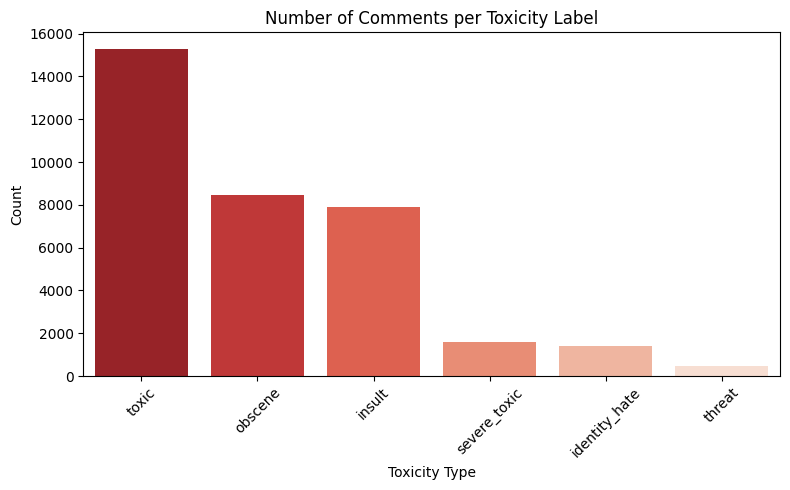

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Total number of comments per label
label_counts = train_df[labels].sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="Reds_r")
plt.title("Number of Comments per Toxicity Label")
plt.ylabel("Count")
plt.xlabel("Toxicity Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Step 3: Text Cleaning, Tokenization, and Padding

In [4]:
# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)                      # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)             # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)                # Remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text).strip()               # Remove extra spaces
    return text

# Apply cleaning
train_df['clean_text'] = train_df['comment_text'].apply(clean_text)

# Tokenization
vocab_size = 10000
max_length = 150
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

# Convert text to sequences and pad them
sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Extract labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train_df[labels].values

# Final shape check
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (159571, 150)
y shape: (159571, 6)


## Step 4: Train-Test Split and Build LSTM Model

In [5]:
# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model using Functional API
input_layer = Input(shape=(150,))
x = Embedding(input_dim=10000, output_dim=64)(input_layer)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(6, activation='sigmoid')(x)  # 6 outputs for multi-label

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Show model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 150, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,302 (2.58 MB)

 Trainable params: 675,302 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Train the LSTM Model

In [6]:
# Define EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128,
    callbacks=[early_stop]
)


Epoch 1/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 102s 100ms/step - accuracy: 0.7563 - loss: 0.1779 - val_accuracy: 0.9941 - val_loss: 0.1440
Epoch 2/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 95s 95ms/step - accuracy: 0.9893 - loss: 0.1418 - val_accuracy: 0.9938 - val_loss: 0.1392
Epoch 3/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.9934 - loss: 0.1082 - val_accuracy: 0.9941 - val_loss: 0.0537
Epoch 4/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - accuracy: 0.9943 - loss: 0.0528 - val_accuracy: 0.9941 - val_loss: 0.0512
Epoch 5/5
998/998 ━━━━━━━━━━━━━━━━━━━━ 104s 104ms/step - accuracy: 0.9939 - loss: 0.0468 - val_accuracy: 0.9941 - val_loss: 0.0526


## Step 6: Evaluate Model Performance

In [11]:
from sklearn.metrics import classification_report

# Predict on validation set
y_pred = model.predict(X_val)

# Convert probabilities to binary values (threshold = 0.5)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Classification report for each label
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print("Multi-label Classification Report:\n")
print(classification_report(y_val, y_pred_binary, target_names=labels))


998/998 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step
Multi-label Classification Report:

               precision    recall  f1-score   support

        toxic       0.87      0.71      0.78      3056
 severe_toxic       0.62      0.04      0.08       321
      obscene       0.86      0.70      0.77      1715
       threat       0.00      0.00      0.00        74
       insult       0.75      0.61      0.67      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.84      0.62      0.71      7074
    macro avg       0.52      0.34      0.38      7074
 weighted avg       0.78      0.62      0.68      7074
  samples avg       0.06      0.06      0.06      7074



## Step 7: Save the Trained Model and Tokenizer

In [8]:
# Save the trained model in .keras format
model.save("multilabel_lstm_model.keras")
print("✅ Model saved as 'multilabel_lstm_model.keras'")

# Save the tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as 'tokenizer.pkl'")


✅ Model saved as 'multilabel_lstm_model.keras'
✅ Tokenizer saved as 'tokenizer.pkl'


## Step 8: Summary and Next Steps

In this notebook, we built and trained a multi-label LSTM model to detect toxic comments across six categories:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

We explored the dataset, cleaned the text, tokenized and padded sequences, trained the model, and evaluated it using multi-label classification metrics. The model and tokenizer were saved for deployment in a Streamlit web application.

### ✅ Next Steps:
- Load this model in a Streamlit app
- Predict all 6 labels in real-time input
- Support CSV upload for batch predictions
- Visualize results and allow CSV download
